# Scalability on PSFC GPU

In [1]:
import matplotlib.pyplot as plt
import json 

In [3]:
import json
import argparse
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

class ScalingPlotter:
    def __init__(self):
        self.models = {}
        self.markers = ['o', 's', '^', 'D', 'v', '<', '>']
        self.colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
        
    def add_model(self, name: str, json_path: str):
        """Load a model's data from a JSON file."""
        with open(json_path, 'r') as f:
            self.models[name] = json.load(f)
            
    def extract_gpu_counts(self, data_dict):
        """Extract GPU counts from gpus_X keys."""
        return [int(k.split('_')[1]) for k in data_dict.keys()]
        
    def plot_strong_scaling(self, 
                          atom_count=None,  # If None, plot all atom counts for one model
                          model_name=None,  # If None, plot all models for one atom count
                          metric='timesteps_per_second',
                          separate_plots=False,
                          output_path=None):
        """
        Plot strong scaling results.
        If atom_count specified: Compare different models for that atom count
        If model_name specified: Compare different atom counts for that model
        """
        plt.figure(figsize=(10, 6))
        
        if model_name and atom_count:
            raise ValueError("Specify either model_name or atom_count, not both")
            
        if model_name:  # Plot different atom counts for one model
            data = self.models[model_name]['strong_scaling']
            for i, (atoms_key, atoms_data) in enumerate(data.items()):
                gpu_counts = self.extract_gpu_counts(atoms_data)
                values = [atoms_data[f'gpus_{gpu}'][metric] for gpu in gpu_counts]
                
                if separate_plots:
                    plt.figure(figsize=(10, 6))
                    
                plt.plot(gpu_counts, values, f'-{self.markers[i]}', 
                        label=f'{atoms_key}', color=self.colors[i])
                
                if separate_plots:
                    plt.title(f'Strong Scaling - {model_name}\n{atoms_key}')
                    plt.xlabel('Number of GPUs')
                    plt.ylabel(metric.replace('_', ' ').title())
                    plt.grid(True)
                    plt.legend()
                    if output_path:
                        plt.savefig(f'{output_path}_{atoms_key}.png')
                    plt.close()
                    
        else:  # Plot different models for one atom count
            for i, (model_name, model_data) in enumerate(self.models.items()):
                if atom_count not in model_data['strong_scaling']:
                    continue
                    
                atoms_data = model_data['strong_scaling'][atom_count]
                gpu_counts = self.extract_gpu_counts(atoms_data)
                values = [atoms_data[f'gpus_{gpu}'][metric] for gpu in gpu_counts]
                
                plt.plot(gpu_counts, values, f'-{self.markers[i]}', 
                        label=f'{model_name}', color=self.colors[i])
                
        if not separate_plots:
            title = f'Strong Scaling - {model_name if model_name else atom_count}'
            plt.title(title)
            plt.xlabel('Number of GPUs')
            plt.ylabel(metric.replace('_', ' ').title())
            plt.grid(True)
            plt.legend()
            if output_path:
                plt.savefig(f'{output_path}.png')
            plt.show()
            
    def plot_weak_scaling(self,
                         atoms_per_gpu=None,  # If None, plot all atoms_per_gpu for one model
                         model_name=None,  # If None, plot all models for one atoms_per_gpu
                         metric='timesteps_per_second',
                         separate_plots=False,
                         output_path=None):
        """
        Plot weak scaling results, normalized to single GPU performance.
        If atoms_per_gpu specified: Compare different models for that configuration
        If model_name specified: Compare different atoms_per_gpu for that model
        """
        plt.figure(figsize=(10, 6))
        
        if model_name and atoms_per_gpu:
            raise ValueError("Specify either model_name or atoms_per_gpu, not both")
            
        if model_name:  # Plot different atoms_per_gpu for one model
            data = self.models[model_name]['weak_scaling']
            for i, (atoms_key, atoms_data) in enumerate(data.items()):
                gpu_counts = self.extract_gpu_counts(atoms_data)
                base_value = atoms_data['gpus_1'][metric]
                values = [atoms_data[f'gpus_{gpu}'][metric]/base_value for gpu in gpu_counts]
                
                if separate_plots:
                    plt.figure(figsize=(10, 6))
                    
                plt.plot(gpu_counts, values, f'-{self.markers[i]}', 
                        label=f'{atoms_key}', color=self.colors[i])
                
                if separate_plots:
                    plt.title(f'Weak Scaling - {model_name}\n{atoms_key}')
                    plt.xlabel('Number of GPUs')
                    plt.ylabel(f'Normalized {metric.replace("_", " ").title()}')
                    plt.grid(True)
                    plt.legend()
                    if output_path:
                        plt.savefig(f'{output_path}_{atoms_key}.png')
                    plt.close()
                    
        else:  # Plot different models for one atoms_per_gpu
            for i, (model_name, model_data) in enumerate(self.models.items()):
                if atoms_per_gpu not in model_data['weak_scaling']:
                    continue
                    
                atoms_data = model_data['weak_scaling'][atoms_per_gpu]
                gpu_counts = self.extract_gpu_counts(atoms_data)
                base_value = atoms_data['gpus_1'][metric]
                values = [atoms_data[f'gpus_{gpu}'][metric]/base_value for gpu in gpu_counts]
                
                plt.plot(gpu_counts, values, f'-{self.markers[i]}', 
                        label=f'{model_name}', color=self.colors[i])
                
        if not separate_plots:
            title = f'Weak Scaling - {model_name if model_name else atoms_per_gpu}'
            plt.title(title)
            plt.xlabel('Number of GPUs')
            plt.ylabel(f'Normalized {metric.replace("_", " ").title()}')
            plt.grid(True)
            plt.legend()
            if output_path:
                plt.savefig(f'{output_path}.png')
            plt.show()

"""

def main():
    
    parser = argparse.ArgumentParser(description='Generate scaling plots from LAMMPS results')
    parser.add_argument('--models', nargs='+', help='Model JSON files in format name:path')
    parser.add_argument('--plot-type', choices=['strong', 'weak'], required=True)
    parser.add_argument('--metric', default='timesteps_per_second', 
                       choices=['ns_per_day', 'hours_per_ns', 'timesteps_per_second', 'katom_steps_per_second'])
    parser.add_argument('--separate', action='store_true', help='Generate separate plots')
    parser.add_argument('--model-name', help='Plot different sizes for this model')
    parser.add_argument('--atom-count', help='For strong scaling: plot different models for this atom count')
    parser.add_argument('--atoms-per-gpu', help='For weak scaling: plot different models for this atoms_per_gpu')
    parser.add_argument('--output', help='Output path for plots (without extension)')
    
    args = parser.parse_args()
    
    plotter = ScalingPlotter()
    
    # Load all model data
    for model_spec in args.models:
        name, path = model_spec.split(':')
        plotter.add_model(name, path)
    
    if args.plot_type == 'strong':
        plotter.plot_strong_scaling(
            atom_count=args.atom_count,
            model_name=args.model_name,
            metric=args.metric,
            separate_plots=args.separate,
            output_path=args.output
        )
    else:
        plotter.plot_weak_scaling(
            atoms_per_gpu=args.atoms_per_gpu,
            model_name=args.model_name,
            metric=args.metric,
            separate_plots=args.separate,
            output_path=args.output
        )
if __name__ == "__main__":
    main()
    
    
"""

'\n\ndef main():\n    \n    parser = argparse.ArgumentParser(description=\'Generate scaling plots from LAMMPS results\')\n    parser.add_argument(\'--models\', nargs=\'+\', help=\'Model JSON files in format name:path\')\n    parser.add_argument(\'--plot-type\', choices=[\'strong\', \'weak\'], required=True)\n    parser.add_argument(\'--metric\', default=\'timesteps_per_second\', \n                       choices=[\'ns_per_day\', \'hours_per_ns\', \'timesteps_per_second\', \'katom_steps_per_second\'])\n    parser.add_argument(\'--separate\', action=\'store_true\', help=\'Generate separate plots\')\n    parser.add_argument(\'--model-name\', help=\'Plot different sizes for this model\')\n    parser.add_argument(\'--atom-count\', help=\'For strong scaling: plot different models for this atom count\')\n    parser.add_argument(\'--atoms-per-gpu\', help=\'For weak scaling: plot different models for this atoms_per_gpu\')\n    parser.add_argument(\'--output\', help=\'Output path for plots (witho

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


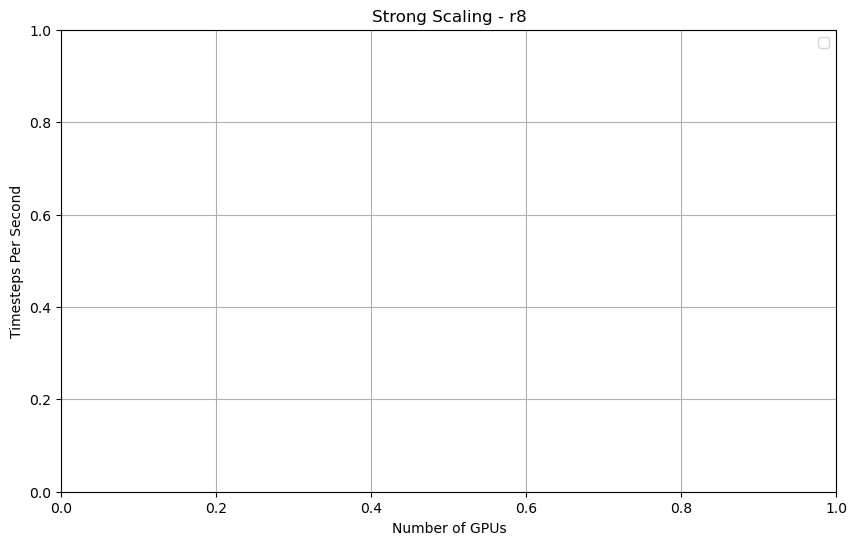

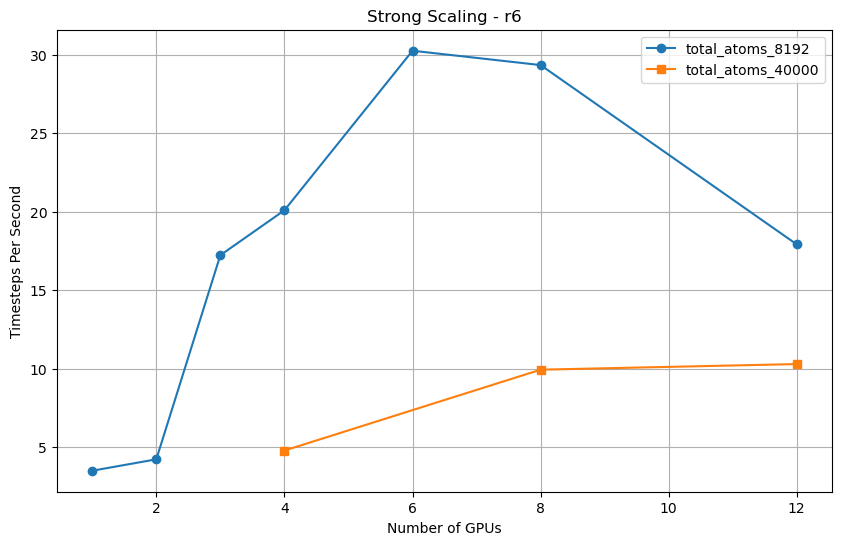

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


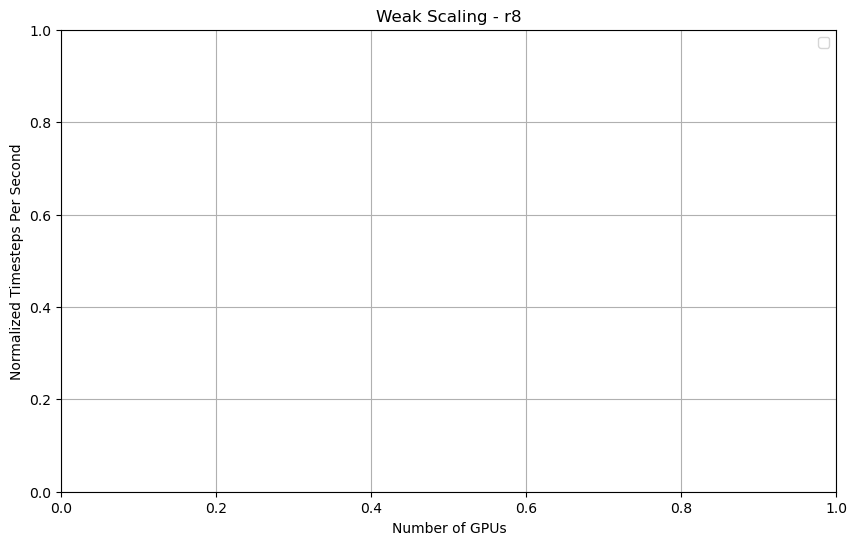

In [5]:
# Initialize the plotter
plotter = ScalingPlotter()

# Define model paths and names
model_paths = {
    'r6': 'data/VCrTiWZr_Scalability_Test/r6_data.json',
    'r7': 'data/VCrTiWZr_Scalability_Test/r7_data.json',
    'r8': 'data/VCrTiWZr_Scalability_Test/r8_data.json'
}

# Load all models
for name, path in model_paths.items():
    plotter.add_model(name, path)

# Example 1: Compare different models for atom count 8192
plotter.plot_strong_scaling(
    atom_count='8192',  # Note: this will look for "total_atoms_8192" in the data
    metric='timesteps_per_second',
    separate_plots=False,
    output_path='strong_scaling_comparison'
)

# Example 2: Compare different atom counts for r6 model
plotter.plot_strong_scaling(
    model_name='r6',
    metric='timesteps_per_second',
    separate_plots=False,
    output_path='r6_strong_scaling'
)

# Example 3: Weak scaling comparison for atoms_per_gpu_1024
plotter.plot_weak_scaling(
    atoms_per_gpu='1024',  # Note: this will look for "atoms_per_gpu_1024" in the data
    metric='timesteps_per_second',
    separate_plots=False,
    output_path='weak_scaling_comparison'
)

[1, 2, 3, 4, 6, 8, 12]
[3.512, 4.238, 17.24, 20.099, 30.263, 29.349, 17.925]
[1, 2, 3, 4, 6, 8, 12]
[1.914, 2.479, 7.034, 11.274, 13.318, 12.106, 16.017]
[1, 2, 3, 4, 6, 8, 12]
[0, 2.292, 2.961, 4.342, 5.735, 6.252, 7.87]


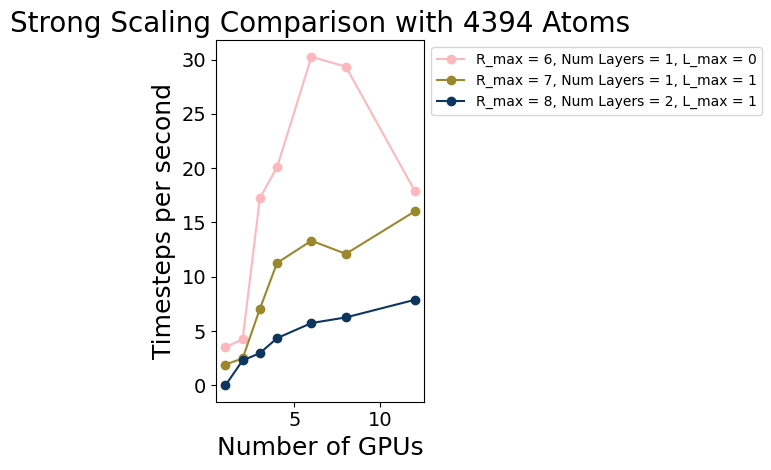

In [10]:
import json
import matplotlib.pyplot as plt

r6_data = json.load(open('data/VCrTiWZr_Scalability_Test/r6_data.json'))
r7_data = json.load(open('data/VCrTiWZr_Scalability_Test/r7_data.json'))
r8_data = json.load(open('data/VCrTiWZr_Scalability_Test/r8_data.json'))

atom_size = 8192 # 8192 or 40000
strong_scaling_r6 = r6_data['strong_scaling'][f'total_atoms_{atom_size}']
num_gpus_r6 = [int(k.split('_')[1]) for k in strong_scaling_r6.keys()]
print(num_gpus_r6)
time_steps_r6 = [strong_scaling_r6[f'gpus_{gpu}']['timesteps_per_second'] for gpu in num_gpus_r6]
print(time_steps_r6)

strong_scaling_r7 = r7_data['strong_scaling'][f'total_atoms_{atom_size}']
num_gpus_r7 = [int(k.split('_')[1]) for k in strong_scaling_r7.keys()]
print(num_gpus_r7)
time_steps_r7 = [strong_scaling_r7[f'gpus_{gpu}']['timesteps_per_second'] for gpu in num_gpus_r7]
print(time_steps_r7)

strong_scaling_r8 = r8_data['strong_scaling'][f'total_atoms_{atom_size}']
num_gpus_r8 = [int(k.split('_')[1]) for k in strong_scaling_r8.keys()]
print(num_gpus_r8)
time_steps_r8 = [strong_scaling_r8[f'gpus_{gpu}'].get('timesteps_per_second', 0) for gpu in num_gpus_r8]
print(time_steps_r8)

real_num_atoms = strong_scaling_r6['gpus_4']['num_atoms']

plt.figure()
plt.title(f"Strong Scaling Comparison with {real_num_atoms} Atoms",fontsize=20)
plt.plot(num_gpus_r6, time_steps_r6, 'o-', color='#fdb8bd', label='R_max = 6, Num Layers = 1, L_max = 0')
plt.plot(num_gpus_r7, time_steps_r7, 'o-', color='#9c882c', label='R_max = 7, Num Layers = 1, L_max = 1')
plt.plot(num_gpus_r8, time_steps_r8, 'o-', color='#0d365f', label='R_max = 8, Num Layers = 2, L_max = 1')
plt.xlabel('Number of GPUs',fontsize=18)
plt.ylabel('Timesteps per second',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)  # Set the tick label size for both axes
#plt.legend()
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Place the legend outside the plot
#plt.tight_layout()
plt.show()

[1, 2, 3, 4, 6, 8, 12]
[3.218, 3.13, 5.35, 6.026, 6.43, 5.332, 5.043]
[1, 2, 3, 4, 6, 8, 12]
[0, 0, 2.867, 2.883, 3.449, 2.798, 2.667]
[1, 2, 3, 4, 6, 8, 12]
[0, 0, 0, 0, 1.379, 0, 0]


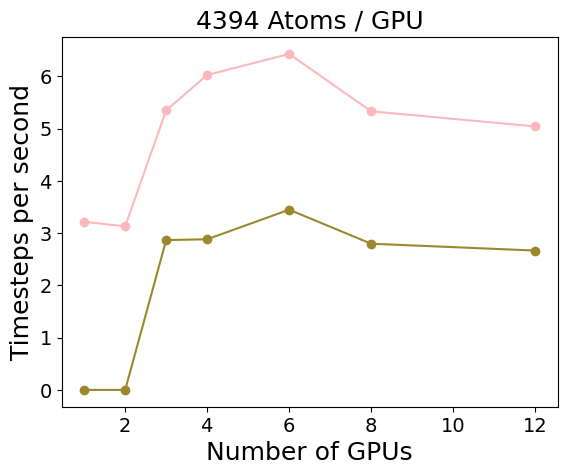

In [19]:
r6_data = json.load(open('data/VCrTiWZr_Scalability_Test/r6_data.json'))
r7_data = json.load(open('data/VCrTiWZr_Scalability_Test/r7_data.json'))
r8_data = json.load(open('data/VCrTiWZr_Scalability_Test/r8_data.json'))

atom_size = 8192 # 1024, 4096, 8192 
# atoms_per_gpu_1024
strong_scaling_r6 = r6_data['weak_scaling'][f'atoms_per_gpu_{atom_size}']
num_gpus_r6 = [int(k.split('_')[1]) for k in strong_scaling_r6.keys()]
print(num_gpus_r6)
time_steps_r6 = [strong_scaling_r6[f'gpus_{gpu}']['timesteps_per_second'] for gpu in num_gpus_r6]
print(time_steps_r6)

strong_scaling_r7 = r7_data['weak_scaling'][f'atoms_per_gpu_{atom_size}']
num_gpus_r7 = [int(k.split('_')[1]) for k in strong_scaling_r7.keys()]
print(num_gpus_r7)
time_steps_r7 = [strong_scaling_r7[f'gpus_{gpu}'].get('timesteps_per_second',0) for gpu in num_gpus_r7]
print(time_steps_r7)

strong_scaling_r8 = r8_data['weak_scaling'][f'atoms_per_gpu_{atom_size}']
num_gpus_r8 = [int(k.split('_')[1]) for k in strong_scaling_r8.keys()]
print(num_gpus_r8)
time_steps_r8 = [strong_scaling_r8[f'gpus_{gpu}'].get('timesteps_per_second', 0) for gpu in num_gpus_r8]
print(time_steps_r8)

real_num_atoms = strong_scaling_r6['gpus_1']['num_atoms']

plt.figure()
plt.title(f"{real_num_atoms} Atoms / GPU",fontsize=18)
plt.plot(num_gpus_r6, time_steps_r6, 'o-', color='#fdb8bd', label='R_max = 6, Num Layers = 1, L_max = 0')
plt.plot(num_gpus_r7, time_steps_r7, 'o-', color='#9c882c', label='R_max = 7, Num Layers = 1, L_max = 1')
#plt.plot(num_gpus_r8, time_steps_r8, 'o-', color='#0d365f', label='R_max = 8, Num Layers = 2, L_max = 1')
plt.xlabel('Number of GPUs',fontsize=18)
plt.ylabel('Timesteps per second',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)  # Set the tick label size for both axes
#plt.legend()
plt.show()

# On Frontier

## Individuals

Extracted Data:
    num_atoms  num_nodes  timesteps_per_sec
0      128000         64             50.396
1      128000          4              6.622
2      128000          1              1.950
3      128000          8             12.391
4      128000         16             21.960
5      128000         32             35.740
6      250000         64             32.788
7      250000          4              3.836
8      250000          1              1.011
9      250000          8              6.743
10     250000         16             12.606
11     250000         32             22.441


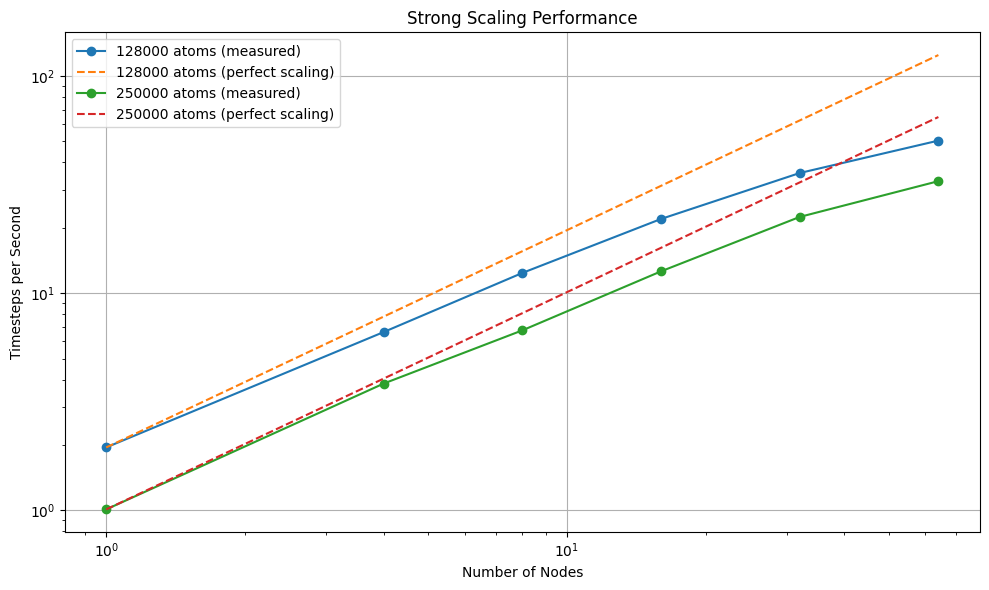

In [8]:
import os
import re
import tarfile
import pandas as pd
import matplotlib.pyplot as plt

# Path to the tar file
#tar_file = "results.tar.gz"

# Extract the tar file
#with tarfile.open(tar_file, "r:gz") as tar:
   # tar.extractall()

results_path = '../data/Frontier_Scaling/results'

# The base directory where the results are stored after extraction
base_dir = os.path.join(results_path, "r5_l2_nl1_ntf32_zbl_gen_6")

# List to collect data
data = []

# Iterate over the num_atoms directories (should be '128000' and '250000')
for num_atoms in os.listdir(base_dir):
    atom_dir = os.path.join(base_dir, num_atoms)
    if os.path.isdir(atom_dir):
        # Iterate over the node directories (e.g., "1_Nodes", "4_Nodes", etc.)
        for node_dir in os.listdir(atom_dir):
            node_path = os.path.join(atom_dir, node_dir)
            if os.path.isdir(node_path):
                # Extract the number of nodes from the directory name (e.g., "1_Nodes" -> 1)
                try:
                    num_nodes = int(node_dir.split('_')[0])
                except ValueError:
                    print(f"Skipping directory {node_dir} because it does not match expected pattern.")
                    continue

                log_file = os.path.join(node_path, "log.lammps")
                if os.path.isfile(log_file):
                    with open(log_file, "r") as f:
                        content = f.read()

                    # Extract timesteps/s from the performance line using regex
                    # The line format is like:
                    # "Performance: 3.088 ns/day, 7.772 hours/ns, 35.740 timesteps/s, 4.575 Matom-step/s"
                    match = re.search(r'Performance:.*?([\d.]+)\s*timesteps/s', content)
                    if match:
                        ts = float(match.group(1))
                        data.append({
                            "num_atoms": int(num_atoms),
                            "num_nodes": num_nodes,
                            "timesteps_per_sec": ts
                        })
                    else:
                        print(f"timesteps/s not found in {log_file}")

# Create a DataFrame from the data collected
df = pd.DataFrame(data)
print("Extracted Data:")
print(df)

# Plotting the strong scaling and perfect scaling curves
plt.figure(figsize=(10, 6))

# Loop over each unique atom count and plot the results
for atoms in sorted(df['num_atoms'].unique()):
    subset = df[df['num_atoms'] == atoms].sort_values('num_nodes')
    nodes = subset['num_nodes']
    ts_measured = subset['timesteps_per_sec']
    
    # Use the performance at 1 node as the baseline for perfect scaling
    baseline = subset[subset['num_nodes'] == 1]['timesteps_per_sec'].iloc[0]
    ts_perfect = baseline * nodes

    plt.plot(nodes, ts_measured, marker='o', label=f"{atoms} atoms (measured)")
    plt.plot(nodes, ts_perfect, linestyle='--', label=f"{atoms} atoms (perfect scaling)")

plt.xlabel("Number of Nodes")
plt.ylabel("Timesteps per Second")
plt.title("Strong Scaling Performance")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Extracted Data:
    num_atoms  num_nodes  timesteps_per_sec
0       54000          1             10.292
1      250000         64             86.490
2      250000          4              8.916
3      250000          1              2.285
4      250000         16             31.164
5      250000         32             55.523
6      601526         64             47.058
7      601526          4              3.663
8      601526          1              0.964
9      601526        128             73.604
10     601526         32             25.921


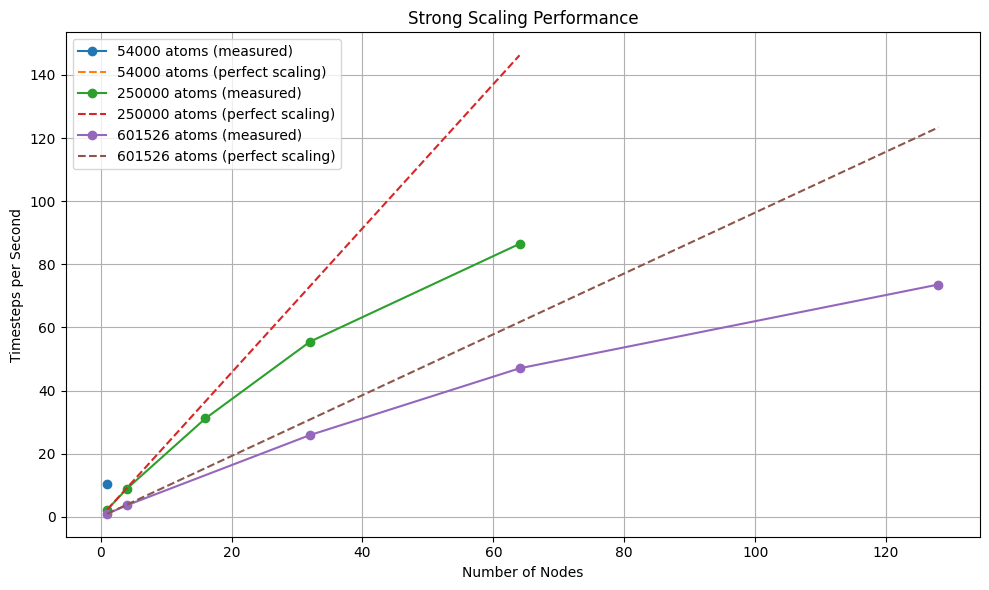

In [2]:
import os
import re
import tarfile
import pandas as pd
import matplotlib.pyplot as plt

# Path to the tar file
#tar_file = "results.tar.gz"

# Extract the tar file
#with tarfile.open(tar_file, "r:gz") as tar:
   # tar.extractall()

results_path = '../data/Frontier_Scaling/new_results'

# The base directory where the results are stored after extraction
base_dir = os.path.join(results_path, "r5_l1_nl2_ntf64_zbl_gen_7")

# List to collect data
data = []

# Iterate over the num_atoms directories (should be '128000' and '250000')
for num_atoms in os.listdir(base_dir):
    atom_dir = os.path.join(base_dir, num_atoms)
    if os.path.isdir(atom_dir):
        # Iterate over the node directories (e.g., "1_Nodes", "4_Nodes", etc.)
        for node_dir in os.listdir(atom_dir):
            node_path = os.path.join(atom_dir, node_dir)
            if os.path.isdir(node_path):
                # Extract the number of nodes from the directory name (e.g., "1_Nodes" -> 1)
                try:
                    num_nodes = int(node_dir.split('_')[0])
                except ValueError:
                    print(f"Skipping directory {node_dir} because it does not match expected pattern.")
                    continue

                log_file = os.path.join(node_path, "log.lammps")
                if os.path.isfile(log_file):
                    with open(log_file, "r") as f:
                        content = f.read()

                    # Extract timesteps/s from the performance line using regex
                    # The line format is like:
                    # "Performance: 3.088 ns/day, 7.772 hours/ns, 35.740 timesteps/s, 4.575 Matom-step/s"
                    match = re.search(r'Performance:.*?([\d.]+)\s*timesteps/s', content)
                    if match:
                        ts = float(match.group(1))
                        data.append({
                            "num_atoms": int(num_atoms),
                            "num_nodes": num_nodes,
                            "timesteps_per_sec": ts
                        })
                    else:
                        print(f"timesteps/s not found in {log_file}")

# Create a DataFrame from the data collected
df = pd.DataFrame(data)
print("Extracted Data:")
print(df)

# Plotting the strong scaling and perfect scaling curves
plt.figure(figsize=(10, 6))

# Loop over each unique atom count and plot the results
for atoms in sorted(df['num_atoms'].unique()):
    subset = df[df['num_atoms'] == atoms].sort_values('num_nodes')
    nodes = subset['num_nodes']
    ts_measured = subset['timesteps_per_sec']
    
    # Use the performance at 1 node as the baseline for perfect scaling
    baseline = subset[subset['num_nodes'] == 1]['timesteps_per_sec'].iloc[0]
    ts_perfect = baseline * nodes

    plt.plot(nodes, ts_measured, marker='o', label=f"{atoms} atoms (measured)")
    plt.plot(nodes, ts_perfect, linestyle='--', label=f"{atoms} atoms (perfect scaling)")

plt.xlabel("Number of Nodes")
plt.ylabel("Timesteps per Second")
plt.title("Strong Scaling Performance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Comparison

Processing directory: ../data/Frontier_Scaling/results/r5_l2_nl1_ntf32_zbl_gen_6 (gen_6)
Processing directory: ../data/Frontier_Scaling/new_results/r5_l1_nl2_ntf64_zbl_gen_7 (gen_7)

Extracted Data:
   run_name  num_atoms  num_nodes  timesteps_per_sec
0     gen_6     128000         64             50.396
1     gen_6     128000          4              6.622
2     gen_6     128000          1              1.950
3     gen_6     128000          8             12.391
4     gen_6     128000         16             21.960
5     gen_6     128000         32             35.740
6     gen_6     250000         64             32.788
7     gen_6     250000          4              3.836
8     gen_6     250000          1              1.011
9     gen_6     250000          8              6.743
10    gen_6     250000         16             12.606
11    gen_6     250000         32             22.441
12    gen_7      54000          1             10.292
13    gen_7     250000         64             86.490
14    

/var/folders/p0/vc4k8wq14yx5wd2wvcxs3qhh0000gn/T/ipykernel_51242/3660755670.py:92: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(df['num_atoms'].unique()) * len(df['run_name'].unique()))


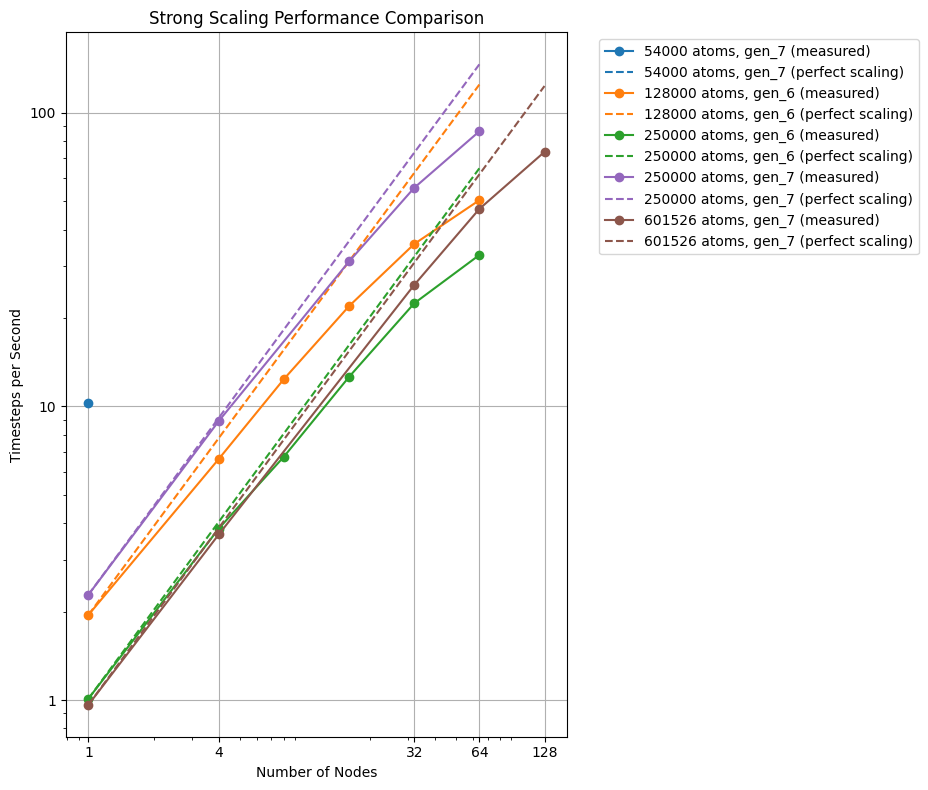

In [4]:
import os
import re
import tarfile
import pandas as pd
import matplotlib.pyplot as plt

# Path to the tar file
#tar_file = "results.tar.gz"

# Extract the tar file
#with tarfile.open(tar_file, "r:gz") as tar:
   # tar.extractall()

# Define the paths to the result directories
# You can add more directories here if needed for future comparisons
result_dirs = {
    "gen_6": "../data/Frontier_Scaling/results/r5_l2_nl1_ntf32_zbl_gen_6",
    "gen_7": "../data/Frontier_Scaling/new_results/r5_l1_nl2_ntf64_zbl_gen_7"
}

# List to collect data
data = []

# Iterate over each specified result directory
for run_name, base_dir in result_dirs.items():
    if not os.path.isdir(base_dir):
        print(f"Warning: Directory not found: {base_dir}. Skipping.")
        continue

    print(f"Processing directory: {base_dir} ({run_name})")

    # Iterate over the num_atoms directories
    # Using listdir() might pick up non-numeric directories, filter for numbers
    for num_atoms_dir_name in os.listdir(base_dir):
        # Check if the directory name is a number
        if not num_atoms_dir_name.isdigit():
            continue

        num_atoms = int(num_atoms_dir_name)
        atom_dir = os.path.join(base_dir, num_atoms_dir_name)

        if os.path.isdir(atom_dir):
            # Iterate over the node directories (e.g., "1_Nodes", "4_Nodes", etc.)
            for node_dir in os.listdir(atom_dir):
                node_path = os.path.join(atom_dir, node_dir)
                if os.path.isdir(node_path):
                    # Extract the number of nodes from the directory name (e.g., "1_Nodes" -> 1)
                    try:
                        # Assuming the format is always NUMBER_Nodes or just NUMBER
                        match = re.match(r'(\d+)(_Nodes)?', node_dir)
                        if match:
                            num_nodes = int(match.group(1))
                        else:
                             print(f"Skipping directory {node_dir} because it does not match expected pattern.")
                             continue
                    except ValueError:
                        print(f"Skipping directory {node_dir} due to unexpected name format.")
                        continue

                    log_file = os.path.join(node_path, "log.lammps")
                    if os.path.isfile(log_file):
                        with open(log_file, "r") as f:
                            content = f.read()

                        # Extract timesteps/s from the performance line using regex
                        # The line format is like:
                        # "Performance: 3.088 ns/day, 7.772 hours/ns, 35.740 timesteps/s, 4.575 Matom-step/s"
                        match = re.search(r'Performance:.*?([\d.]+)\s*timesteps/s', content)
                        if match:
                            ts = float(match.group(1))
                            data.append({
                                "run_name": run_name, # Add the run name
                                "num_atoms": num_atoms,
                                "num_nodes": num_nodes,
                                "timesteps_per_sec": ts
                            })
                        else:
                            print(f"timesteps/s not found in {log_file}")

# Create a DataFrame from the data collected
df = pd.DataFrame(data)
print("\nExtracted Data:")
print(df)

# Plotting the strong scaling and perfect scaling curves
plt.figure(figsize=(12, 8)) # Slightly larger figure

# Get unique combinations of run_name and num_atoms
unique_configs = df[['run_name', 'num_atoms']].drop_duplicates().sort_values(['num_atoms', 'run_name'])

# Define some colors and markers for different runs/atom counts
colors = plt.cm.get_cmap('tab10', len(df['num_atoms'].unique()) * len(df['run_name'].unique()))
line_styles = ['-', '--', ':'] # Different styles for measured vs perfect scaling or different runs

i = 0 # Counter for color mapping
# Loop over each unique configuration (run_name and num_atoms)
for index, row in unique_configs.iterrows():
    run_name = row['run_name']
    atoms = row['num_atoms']

    subset = df[(df['num_atoms'] == atoms) & (df['run_name'] == run_name)].sort_values('num_nodes')

    # Check if we have data for 1 node for this configuration to calculate baseline
    baseline_subset = subset[subset['num_nodes'] == 1]

    if baseline_subset.empty:
        print(f"Warning: No data for 1 node found for {atoms} atoms in {run_name}. Cannot plot perfect scaling.")
        # Plot only the measured data if available
        if not subset.empty:
             plt.plot(subset['num_nodes'], subset['timesteps_per_sec'], marker='o', color=colors(i), linestyle='-', label=f"{atoms} atoms, {run_name} (measured)")
             i += 1 # Increment color counter even if only measured is plotted
        continue # Skip perfect scaling if no 1-node data

    baseline = baseline_subset['timesteps_per_sec'].iloc[0]

    # Plot measured data
    plt.plot(subset['num_nodes'], subset['timesteps_per_sec'], marker='o', color=colors(i), linestyle='-', label=f"{atoms} atoms, {run_name} (measured)")

    # Calculate and plot perfect scaling
    nodes = sorted(subset['num_nodes'].unique()) # Use all nodes present in the subset for perfect scaling line
    ts_perfect = baseline * pd.Series(nodes) # Calculate perfect scaling for the range of nodes present

    # Plot perfect scaling line - use the same color but different linestyle
    plt.plot(nodes, ts_perfect, color=colors(i), linestyle='--', label=f"{atoms} atoms, {run_name} (perfect scaling)")

    i += 1 # Increment color counter after plotting a config's measured and perfect lines

plt.xlabel("Number of Nodes")
plt.ylabel("Timesteps per Second")
plt.title("Strong Scaling Performance Comparison")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside plot
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.8, 1]) # Adjust layout to make space for legend
plt.xscale('log') # Use log scale for x-axis (nodes) for better visualization of doubling
plt.yscale('log') # Use log scale for y-axis (timesteps/s) for scaling comparison
plt.xticks(subset['num_nodes'].unique(), subset['num_nodes'].unique()) # Set x-ticks to actual node counts
from matplotlib.ticker import ScalarFormatter
for axis in [plt.gca().xaxis, plt.gca().yaxis]:
    axis.set_major_formatter(ScalarFormatter())

plt.show()

Processing directory: ../data/Frontier_Scaling/results/r5_l2_nl1_ntf32_zbl_gen_6 (gen_6)
Processing directory: ../data/Frontier_Scaling/new_results/r5_l1_nl2_ntf64_zbl_gen_7 (gen_7)
Log file not found: ../data/Frontier_Scaling/new_results/r5_l1_nl2_ntf64_zbl_gen_7/601526/16_Nodes/log.lammps

Extracted Data:
   run_name  num_atoms  num_nodes  timesteps_per_sec
0     gen_6     128000         64             50.396
1     gen_6     128000          4              6.622
2     gen_6     128000          1              1.950
3     gen_6     128000          8             12.391
4     gen_6     128000         16             21.960
5     gen_6     128000         32             35.740
6     gen_6     250000         64             32.788
7     gen_6     250000          4              3.836
8     gen_6     250000          1              1.011
9     gen_6     250000          8              6.743
10    gen_6     250000         16             12.606
11    gen_6     250000         32             22.441
12

/var/folders/p0/vc4k8wq14yx5wd2wvcxs3qhh0000gn/T/ipykernel_51242/1971058163.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_unique_configs if num_unique_configs <= 10 else 20) # Use tab10 or tab20


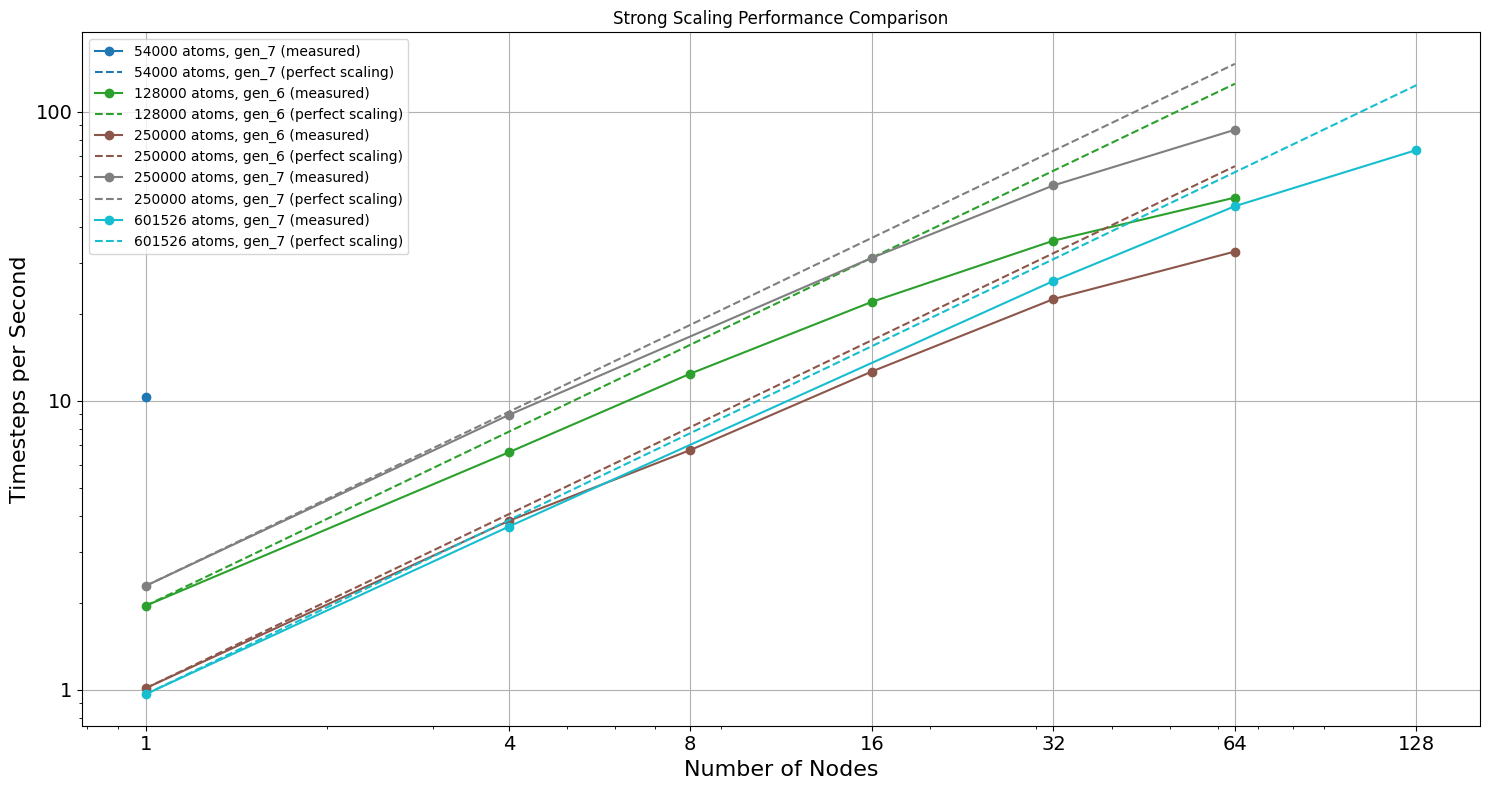

In [7]:
import os
import re
import tarfile
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Path to the tar file
#tar_file = "results.tar.gz"

# Extract the tar file
#with tarfile.open(tar_file, "r:gz") as tar:
   # tar.extractall()

# Define the paths to the result directories
# You can add more directories here if needed for future comparisons
result_dirs = {
    "gen_6": "../data/Frontier_Scaling/results/r5_l2_nl1_ntf32_zbl_gen_6",
    "gen_7": "../data/Frontier_Scaling/new_results/r5_l1_nl2_ntf64_zbl_gen_7"
}

# List to collect data
data = []

# Iterate over each specified result directory
for run_name, base_dir in result_dirs.items():
    if not os.path.isdir(base_dir):
        print(f"Warning: Directory not found: {base_dir}. Skipping.")
        continue

    print(f"Processing directory: {base_dir} ({run_name})")

    # Iterate over the num_atoms directories
    # Using listdir() might pick up non-numeric directories, filter for numbers
    for num_atoms_dir_name in os.listdir(base_dir):
        # Check if the directory name is a number
        if not num_atoms_dir_name.isdigit():
            # You might want to print a message here if you expect only numeric dirs
            # print(f"Skipping non-numeric directory: {num_atoms_dir_name} in {base_dir}")
            continue

        num_atoms = int(num_atoms_dir_name)
        atom_dir = os.path.join(base_dir, num_atoms_dir_name)

        if os.path.isdir(atom_dir):
            # Iterate over the node directories (e.g., "1_Nodes", "4_Nodes", etc.)
            for node_dir in os.listdir(atom_dir):
                node_path = os.path.join(atom_dir, node_dir)
                if os.path.isdir(node_path):
                    # Extract the number of nodes from the directory name (e.g., "1_Nodes" -> 1)
                    try:
                        # Assuming the format is always NUMBER_Nodes or just NUMBER
                        match = re.match(r'(\d+)(_Nodes)?', node_dir)
                        if match:
                            num_nodes = int(match.group(1))
                        else:
                             print(f"Skipping directory {node_dir} in {atom_dir} because it does not match expected pattern (e.g., '1_Nodes' or '1').")
                             continue
                    except ValueError: # Should not happen with isdigit and re.match combo, but good practice
                        print(f"Skipping directory {node_dir} in {atom_dir} due to unexpected name format.")
                        continue

                    log_file = os.path.join(node_path, "log.lammps")
                    if os.path.isfile(log_file):
                        with open(log_file, "r") as f:
                            content = f.read()

                        # Extract timesteps/s from the performance line using regex
                        # The line format is like:
                        # "Performance: 3.088 ns/day, 7.772 hours/ns, 35.740 timesteps/s, 4.575 Matom-step/s"
                        perf_match = re.search(r'Performance:.*?([\d.]+)\s*timesteps/s', content)
                        if perf_match:
                            ts = float(perf_match.group(1))
                            data.append({
                                "run_name": run_name, # Add the run name
                                "num_atoms": num_atoms,
                                "num_nodes": num_nodes,
                                "timesteps_per_sec": ts
                            })
                        else:
                            print(f"timesteps/s not found in {log_file}")
                    else:
                        print(f"Log file not found: {log_file}")

# Create a DataFrame from the data collected
df = pd.DataFrame(data)
print("\nExtracted Data:")
if df.empty:
    print("No data was extracted. Please check your paths and file structures.")
else:
    print(df)

# Plotting the strong scaling and perfect scaling curves
if not df.empty:
    plt.figure(figsize=(15, 8)) # Made the figure wider

    # Get unique combinations of run_name and num_atoms, sorted for consistent plotting order
    unique_configs = df[['run_name', 'num_atoms']].drop_duplicates().sort_values(['num_atoms', 'run_name'])

    # Define some colors and markers for different runs/atom counts
    # Ensure enough colors for all unique configs
    num_unique_configs = len(unique_configs)
    if num_unique_configs > 0:
        colors = plt.cm.get_cmap('tab10', num_unique_configs if num_unique_configs <= 10 else 20) # Use tab10 or tab20
    else:
        colors = lambda x: 'blue' # Default if no configs

    i = 0 # Counter for color mapping
    # Loop over each unique configuration (run_name and num_atoms)
    for index, row in unique_configs.iterrows():
        run_name = row['run_name']
        atoms = row['num_atoms']

        subset = df[(df['num_atoms'] == atoms) & (df['run_name'] == run_name)].sort_values('num_nodes')

        if subset.empty:
            print(f"No data for configuration: {atoms} atoms, {run_name}. Skipping plot for this config.")
            continue

        # Check if we have data for 1 node for this configuration to calculate baseline
        baseline_subset = subset[subset['num_nodes'] == 1]
        
        # Plot measured data
        plt.plot(subset['num_nodes'], subset['timesteps_per_sec'], marker='o', color=colors(i % colors.N), linestyle='-', label=f"{atoms} atoms, {run_name} (measured)")

        if baseline_subset.empty:
            print(f"Warning: No data for 1 node found for {atoms} atoms in {run_name}. Cannot plot perfect scaling line.")
        else:
            baseline_ts = baseline_subset['timesteps_per_sec'].iloc[0]
            # Calculate and plot perfect scaling
            # Use all nodes present in the subset for perfect scaling line
            # Make sure nodes are numeric for multiplication
            perfect_scaling_nodes = pd.to_numeric(subset['num_nodes'].unique())
            perfect_scaling_nodes.sort() # ensure sorted for line plot
            ts_perfect = baseline_ts * perfect_scaling_nodes

            # Plot perfect scaling line - use the same color but different linestyle
            plt.plot(perfect_scaling_nodes, ts_perfect, color=colors(i % colors.N), linestyle='--', label=f"{atoms} atoms, {run_name} (perfect scaling)")

        i += 1 # Increment color counter after plotting a config's measured and perfect lines

    plt.xlabel("Number of Nodes", fontsize=16)
    plt.ylabel("Timesteps per Second", fontsize=16)
    plt.title("Strong Scaling Performance Comparison")
    plt.legend(loc='best', fontsize='medium') # Move legend inside, let matplotlib find the 'best' location, adjust fontsize
    plt.grid(True)
    
    plt.xscale('log') # Use log scale for x-axis (nodes) for better visualization of doubling
    plt.yscale('log') # Use log scale for y-axis (timesteps/s) for scaling comparison

    # Ensure all unique node counts are shown as x-ticks
    if not df['num_nodes'].empty:
        all_nodes = sorted(df['num_nodes'].unique())
        plt.xticks(all_nodes, all_nodes, fontsize=14) # Set x-ticks to actual node counts
    
    plt.yticks(fontsize=14)

    # Apply scalar formatter to avoid scientific notation on axes if not desired
    for axis in [plt.gca().xaxis, plt.gca().yaxis]:
        axis.set_major_formatter(ScalarFormatter())
    
    plt.tight_layout() # Adjust layout after all elements are added
    plt.show()
else:
    print("DataFrame is empty, skipping plot generation.")
